[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Zero-Shot Object Detection with Qwen2.5-VL

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-qwen2-5-vl.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.13923-b31b1b.svg)](https://arxiv.org/abs/2502.13923)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/QwenLM/Qwen2.5-VL)

Qwen2.5-VL is the latest vision-language model in the Qwen series, delivering state-of-the-art capabilities for understanding and analyzing images, text, and documents. Available in three sizes (3B, 7B, and 72B), it excels in tasks such as precise object localization with bounding boxes, enhanced OCR for multi-language and multi-orientation text recognition, and structured data extraction from formats like invoices, forms, and tables. With advanced image recognition spanning plants, animals, landmarks, and products, Qwen2.5-VL sets a new benchmark for multimodal understanding, catering to diverse domains including finance, commerce, and digital intelligence.

![Qwen2.5-VL](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/qwen2.5vl_arc.jpeg)

## Environment setup

### Configure your API keys

To benchmark Qwen2.5-VL, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Thu Jul 17 12:22:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

Installs all required python libraries, including [`maestro`](https://github.com/roboflow/maestro) for Qwen2.5-VL and [`supervision`](https://github.com/roboflow/supervision) for visualization.

In [ ]:
!pip install -q "maestro[qwen_2_5_vl]==1.1.0rc2"
!pip install -q supervision==0.26.0

### Download example data

In [4]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Load Qwen2.5-VL model

Loads the Qwen2.5-VL model (and its processor) from Hugging Face, preparing the model for inference.

In [ ]:
from maestro.trainer.models.qwen_2_5_vl.checkpoints import load_model, OptimizationStrategy

MODEL_ID_OR_PATH = "Qwen/Qwen2.5-VL-7B-Instruct"
MIN_PIXELS = 512 * 28 * 28
MAX_PIXELS = 2048 * 28 * 28

processor, model = load_model(
    model_id_or_path=MODEL_ID_OR_PATH,
    optimization_strategy=OptimizationStrategy.NONE,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)

## Qwen2.5-VL inference and visualization

### Define helper functions

Creates a function to run text prompts against the Qwen2.5-VL model and parse the results.

In [7]:
from PIL import Image
from typing import Optional, Tuple, Union

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info

def run_qwen_2_5_vl_inference(
    model,
    processor,
    image: Image.Image,
    prompt: str,
    system_message: Optional[str] = None,
    device: str = "auto",
    max_new_tokens: int = 1024,
) -> Tuple[str, Tuple[int, int]]:
    device = parse_device_spec(device)
    conversation = format_conversation(image=image, prefix=prompt, system_message=system_message)
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=text,
        images=image_inputs,
        return_tensors="pt",
    )

    input_h = inputs['image_grid_thw'][0][1] * 14
    input_w = inputs['image_grid_thw'][0][2] * 14

    response = predict_with_inputs(
        **inputs,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=max_new_tokens
    )[0]

    return response, (int(input_w), int(input_h))

Creates a function to annotate an image with detection results.

In [18]:
import supervision as sv
from PIL import Image


def annotate_image(image: Image, detections: sv.Detections) -> Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    if detections.mask is not None:
        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
        image = mask_annotator.annotate(image, detections)
    else:
        box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX, thickness=thickness)
        image = box_annotator.annotate(image, detections)

    label_annotator = sv.LabelAnnotator(
        color_lookup=sv.ColorLookup.INDEX,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness - 1,
        smart_position=True
    )
    image = label_annotator.annotate(image, detections)
    return image

### Detect "each chair"

Prompts the model to detect all chairs in the image, outputs JSON coordinates, and visualizes detections.

In [19]:
IMAGE_PATH = "/content/dog-3.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of each chair and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [74, 631, 465, 1138], "label": "chair"},
	{"bbox_2d": [409, 512, 545, 700], "label": "chair"},
	{"bbox_2d": [515, 550, 728, 733], "label": "chair"},
	{"bbox_2d": [625, 515, 728, 728], "label": "chair"}
]
```


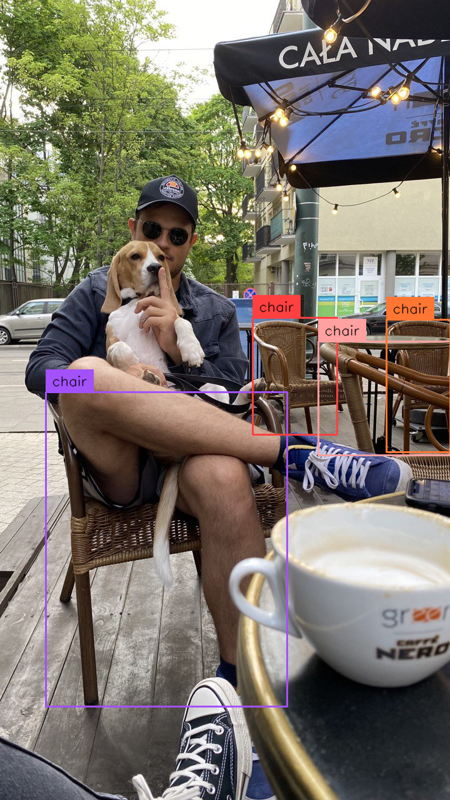

In [20]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

### Detect "chair with man sitting on it"

Filters the request to a more specific target object and visualizes the bounding box.

In [21]:
IMAGE_PATH = "/content/dog-3.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of chair with man sitting on it and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [74, 630, 465, 1138], "label": "chair with man sitting on it"}
]
```


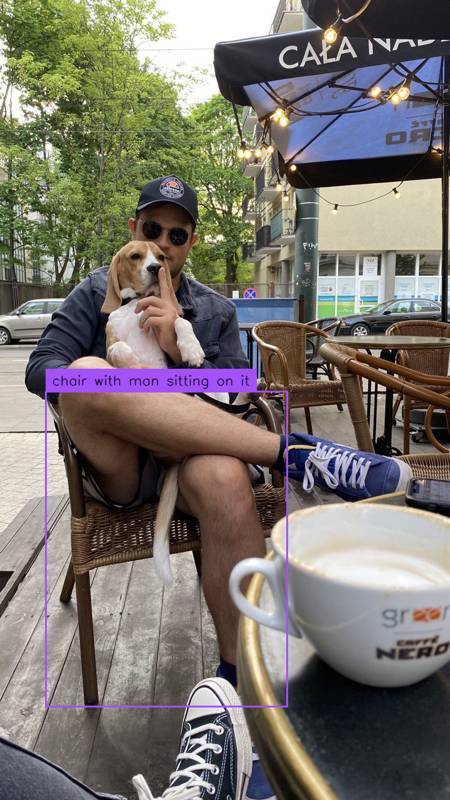

In [22]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

### Detect multiple objects

Prompts the model to find several objects (chair, dog, etc.) in the image, then visualizes the results.

In [23]:
IMAGE_PATH = "/content/dog-3.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of chair, dog, table, shoe, light bulb, coffee, hat, glasses, car, tail, umbrella and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [406, 513, 579, 700], "label": "chair"},
	{"bbox_2d": [518, 550, 728, 733], "label": "chair"},
	{"bbox_2d": [626, 515, 728, 729], "label": "chair"},
	{"bbox_2d": [73, 632, 466, 1136], "label": "chair"},
	{"bbox_2d": [166, 386, 432, 946], "label": "dog"},
	{"bbox_2d": [370, 789, 728, 1288], "label": "table"},
	{"bbox_2d": [213, 1090, 435, 1288], "label": "shoe"},
	{"bbox_2d": [435, 806, 728, 1110], "label": "coffee"},
	{"bbox_2d": [429, 174, 468, 204], "label": "light bulb"},
	{"bbox_2d": [468, 262, 484, 277], "label": "light bulb"},
	{"bbox_2d": [409, 230, 443, 254], "label": "light bulb"},
	{"bbox_2d": [451, 202, 470, 220], "label": "light bulb"},
	{"bbox_2d": [418, 229, 436, 246], "label": "light bulb"},
	{"bbox_2d": [435, 234, 445, 249], "label": "light bulb"},
	{"bbox_2d": [445, 236, 455, 250], "label": "light bulb"},
	{"bbox_2d": [458, 264, 473, 277], "label": "light bulb"},
	{"bbox_2d": [487, 292, 497, 303], "label": "light bulb"},
	{"bbox_2d": [538, 333, 5

Sometimes, if there are too many objects in the image, or we try to detect many classes at once, the model can get confused.

In [24]:
IMAGE_PATH = "/content/dog-3.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of chair, dog, table, shoe, coffee, hat, glasses, car, tail, umbrella and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [73, 618, 465, 1139], "label": "chair"},
	{"bbox_2d": [406, 512, 548, 700], "label": "chair"},
	{"bbox_2d": [515, 550, 728, 732], "label": "chair"},
	{"bbox_2d": [626, 515, 728, 727], "label": "chair"},
	{"bbox_2d": [167, 385, 432, 947], "label": "dog"},
	{"bbox_2d": [370, 789, 728, 1288], "label": "table"},
	{"bbox_2d": [213, 1090, 433, 1288], "label": "shoe"},
	{"bbox_2d": [436, 833, 728, 1110], "label": "coffee"},
	{"bbox_2d": [222, 280, 320, 366], "label": "hat"},
	{"bbox_2d": [224, 352, 307, 400], "label": "glasses"},
	{"bbox_2d": [542, 479, 728, 542], "label": "car"},
	{"bbox_2d": [0, 481, 110, 554], "label": "car"},
	{"bbox_2d": [247, 749, 285, 948], "label": "tail"},
	{"bbox_2d": [344, 0, 728, 304], "label": "umbrella"}
]
```


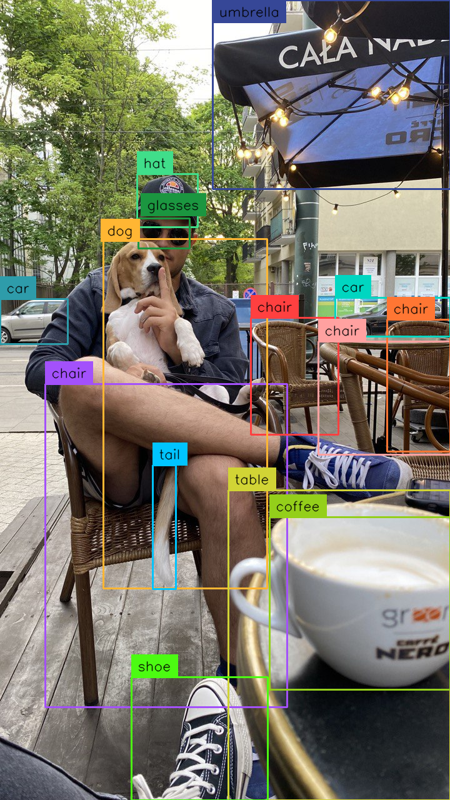

In [25]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

### Detect "glass"

Asks the model to outline the glass in the image, then annotates and displays it.

In [26]:
IMAGE_PATH = "/content/dog-2.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of glass and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [478, 895, 647, 1139], "label": "glass"},
	{"bbox_2d": [315, 850, 447, 1045], "label": "glass"}
]
```


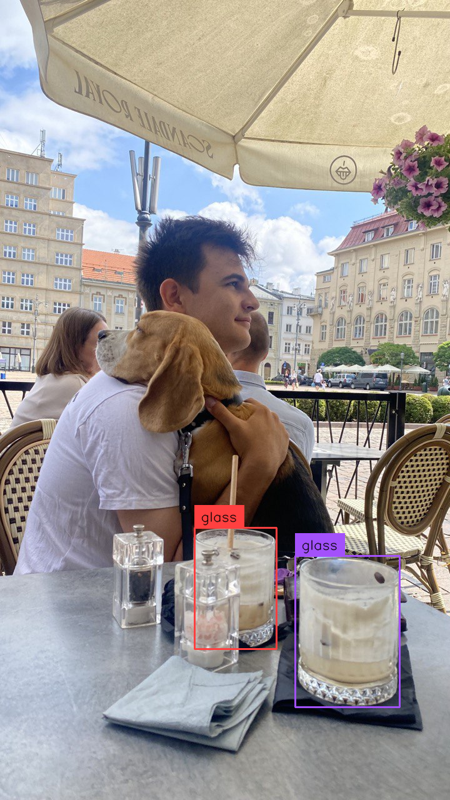

In [27]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

### Detect "glass most to the right"

Narrows down to a specific instance of a class (the rightmost glass).

In [28]:
IMAGE_PATH = "/content/dog-2.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of glass most to the right and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [478, 895, 647, 1139], "label": "glass most to the right"}
]
```


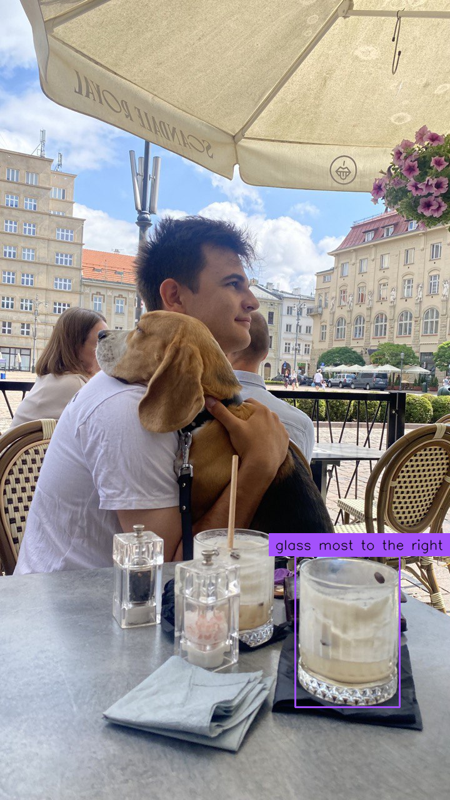

In [29]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

### Detect "straw"

In [30]:
IMAGE_PATH = "/content/dog-2.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of straw and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [369, 731, 385, 884], "label": "straw"}
]
```


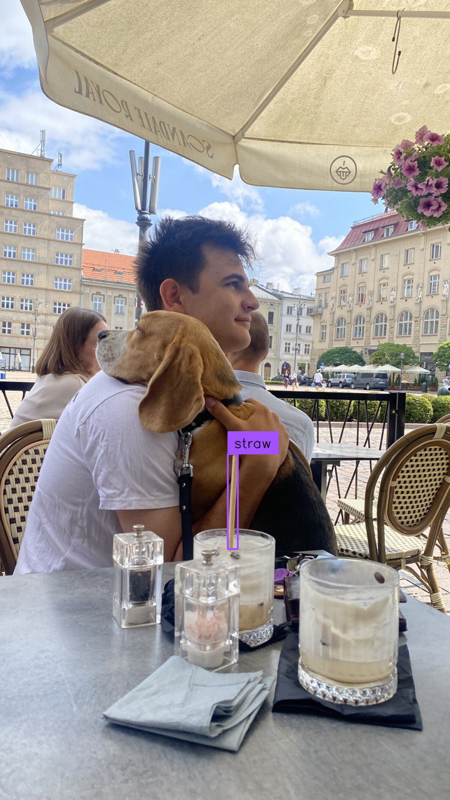

In [31]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

### Detect "pepper" and "salt"

In [32]:
IMAGE_PATH = "/content/dog-2.jpeg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of pepper, salt and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [180, 845, 267, 1013], "label": "pepper"},
	{"bbox_2d": [283, 884, 390, 1074], "label": "salt"}
]
```


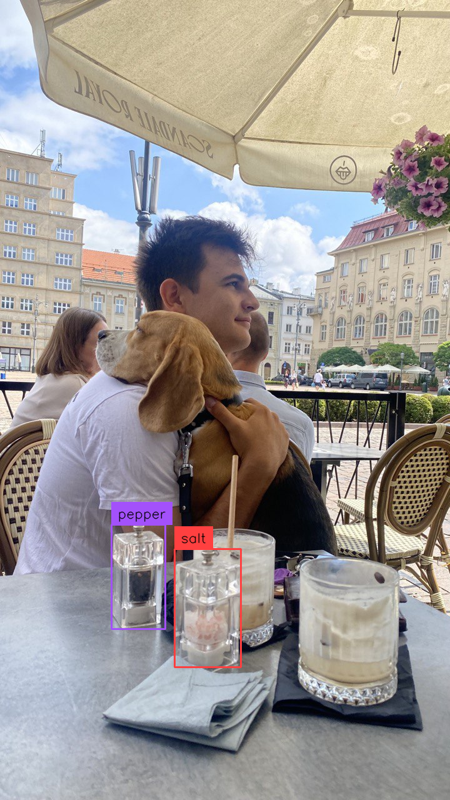

In [33]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

## Qwen2.5-VL on Roboflow dataset

### Download and load dataset

Installs the [`roboflow`](https://github.com/roboflow/roboflow-python) SDK, downloads a dataset, and load it as `DetectionDataset` using `supervision`.

In [34]:
!pip install -q roboflow

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/work-safe-project/safety-vest---v4/dataset/3", "coco")

In [36]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

### Inference on Roboflow dataset

Runs Qwen2.5-VL on a real-world dataset image (detecting helmets), then visualizes detections.

In [37]:
image_path, _, annotations = ds[0]
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of helmet and output all the coordinates in JSON format."

image = Image.open(image_path)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [130, 145, 210, 197], "label": "helmet"},
	{"bbox_2d": [218, 160, 299, 210], "label": "helmet"},
	{"bbox_2d": [30, 169, 143, 231], "label": "helmet"}
]
```


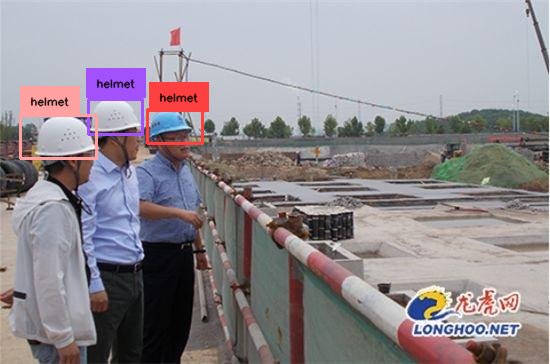

In [38]:
import supervision as sv

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.QWEN_2_5_VL,
    result=response,
    input_wh=input_wh,
    resolution_wh=resolution_wh
)
image = annotate_image(image=image, detections=detections)
image.thumbnail((800, 800))
image

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>